# Playing around with Predictions

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Local imports - these functions are located in ./local_definitions.py
from local_definitions import plot_confusion_matrix
from local_definitions import plot_accuracy_with_errorbar
from local_definitions import plot_accuracy
from local_definitions import print_max_accuracy

In [3]:
# Run this cell if you're having problems with pickle

# import sys
# !{sys.executable} -m pip install --upgrade pandas

In [4]:
# Import data from main_notebook.ipynb

import pickle

pickle_in = open("./data/games_dfs.pickle","rb")
games = pickle.load(pickle_in)
pickle_in.close()

games_10_df = games["games_10_df"]
games_14_df = games["games_14_df"]
games_18_df = games["games_18_df"]
games_comb_df = games["games_comb_df"]

features_list = games["features_list"] # sorted alphabetically

avg_importance_scores_df = games["avg_importance_scores_df"] # most important to least important
features_array = games["features_array"] # sorted from most important to least important

In [5]:
features_dict = {
    "out_of_game" : ["value","top100","rank"],
    "in_game" : ["passes completed", "total passes", "passes acc", "total shots", "on-target", "possession",
                  "distance", "distance poss", "distance not poss", "offsides", "fouls committed", "fouls suffered",
                  "yellow", "red", "high intensity", "low intensity", "sprints", "time opp half", "time opp third"],
    "all_features" : features_list
}

In [6]:
# Given a vector of accuracy ("score") values for different numbers of features, print the maximum
def print_max_accuracy(scores, mode='testing'):
    print(f"Max score in {mode}: = {np.round(np.max(scores), 3)} with {np.argmax(scores) + 1} features")
    
def plot_accuracy_with_errorbar(xdata, train_scores, train_err, test_scores, test_err, clf_name='Random Forest', 
                  xaxis_title='number of features', yaxis_title='accuracy', print_max=True):
    
    fig = go.Figure(go.Scatter(
        x=xdata,
        y=train_scores,
        error_y=dict(
            type='data', 
            array=train_err,
            visible=True),
        name ="Training accuracy w/ CV"
        ))
    fig.add_trace(go.Scatter(
        x=xdata,
        y=test_scores,
        error_y=dict(
            type='data', 
            array=test_err,
            visible=True),
        name="Testing accuracy"))

    fig.update_layout(title=f"Training and testing accuracies for {clf_name}",
                      xaxis_title='number of features',
                      yaxis_title='accuracy')
    fig.show()
    
    if print_max:
        print_max_accuracy(train_scores, mode='training')
        print_max_accuracy(test_scores, mode='testing')

## Playing around with Neural Networks

In [7]:
# Classification using Neural Network

binary = False
random = 42  # None for random data split and random initialization of model. Any integer for a seed.

# how many features to use? (None for all features)
n_feats = 5; 

# Split data into train, test sets
X = pd.DataFrame(games_comb_df[features_array[0:n_feats]])
y = pd.DataFrame(games_comb_df['WDL'])
if binary:
    y[y==0] = -1 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random)

pipeline = Pipeline([
        ('scale', StandardScaler()),
        ('clf', MLPClassifier(solver='lbfgs', random_state=random))])

hyperparameters = {
    'clf__hidden_layer_sizes' : [(2,),(3,),(4,),(2,2),(4,4),(5,2),(4,2)],
    'clf__alpha' : [5,10] # regularization parameter, helps avoid overfitting
}
               
# Do a grid search with cross validation to find the best hyperparameter values
grid = GridSearchCV(pipeline, param_grid=hyperparameters, cv=5, verbose=0, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

# Display results
cols_of_interest = ['mean_test_score', 'std_test_score', 'rank_test_score'] + [c.replace('clf', 'param_clf') for c in hyperparameters.keys()]
results = pd.DataFrame(grid.cv_results_).sort_values(by=['mean_test_score'], ascending=False)[cols_of_interest]
results.head(10) 

,mean_test_score,std_test_score,rank_test_score,param_clf__hidden_layer_sizes,param_clf__alpha
6,0.641789,0.036073,1,"(4, 2)",5
0,0.638155,0.037278,2,"(2,)",5
5,0.638015,0.042217,3,"(5, 2)",5
7,0.634382,0.039543,4,"(2,)",10
8,0.634382,0.033944,4,"(3,)",10
9,0.634382,0.039543,4,"(4,)",10
12,0.634382,0.033944,4,"(5, 2)",10
13,0.634382,0.033944,4,"(4, 2)",10
3,0.634312,0.038571,9,"(2, 2)",5
11,0.630678,0.035245,10,"(4, 4)",10


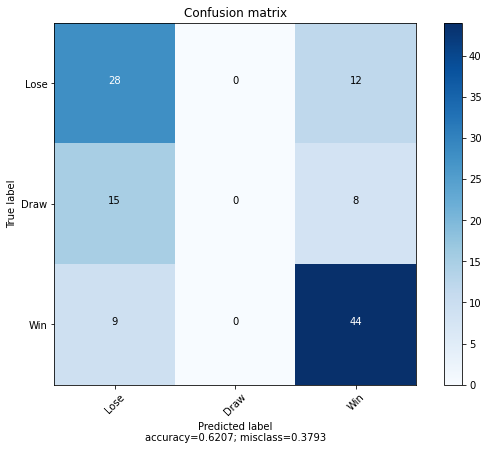

In [8]:
grid.refit

labels = ['Lose or Draw', 'Win'] if binary else ['Lose', 'Draw', 'Win']

preds = grid.predict(X_test)
plot_confusion_matrix(confusion_matrix(y_test, preds), labels, normalize=False)

## SVC stuff

In [142]:
# Classification using SVC (Can only do Binary classification for now)

binary = True

# how many features to use? (None for all features)
n_feats = 12; 

# Split data into train, test sets
X = pd.DataFrame(games_comb_df[features_array[0:n_feats]])
y = pd.DataFrame(games_comb_df['WDL'])
if binary:
    y[y==0] = -1 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

pipeline = Pipeline([
        ('scale', StandardScaler()),
        ('clf', SVC())])

hyperparameters = {
    'clf__kernel' : ['linear'],
    'clf__degree' : [1],
    'clf__C'      : [0.1, 1]
}

"""
Hyperparameter analysis with grid search cross validation yields:
    kernel: 'linear' OR 'poly' with 'degree'=1. ('rbf' and 'sigmoid' perform badly)
    C: values between 1 and 4 seem to be best, ideal=1.2

""" 
               
# Do a grid search with cross validation to find the best hyperparameter values
grid = GridSearchCV(pipeline, param_grid=hyperparameters, cv=5, verbose=0, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

# Display results
cols_of_interest = ['mean_test_score', 'std_test_score', 'rank_test_score'] + [c.replace('clf', 'param_clf') for c in hyperparameters.keys()]
results = pd.DataFrame(grid.cv_results_).sort_values(by=['mean_test_score'], ascending=False)[cols_of_interest]
results.head(10) 

,mean_test_score,std_test_score,rank_test_score,param_clf__kernel,param_clf__degree,param_clf__C
0,0.754018,0.059554,1,linear,1,0.1
1,0.731656,0.063238,2,linear,1,1


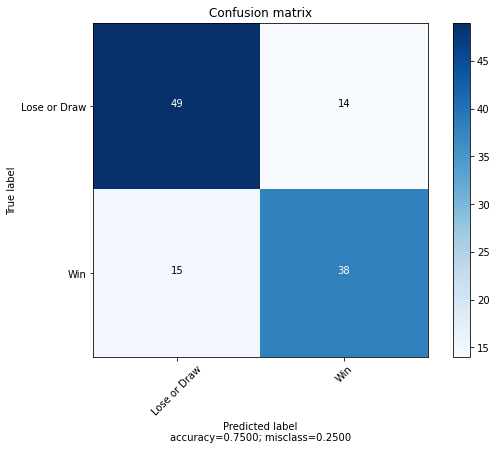

In [143]:
grid.refit

preds = grid.predict(X_test)
plot_confusion_matrix(confusion_matrix(y_test, preds), ['Lose or Draw', 'Win'], normalize=False)

## Random Forest stuff

I am tempted to try using an ExtraTreesClassifier. More research is required.

from sklearn.ensemble import ExtraTreesClassifier

In [11]:
# Classification using Random Forest

binary = False # Binary Classification Flag. 
random = None  # None for random data split and random initialization of model. Any integer for a seed.

# how many features to use? (None for all features)
n_feats = None; 

# Split data into train, test sets
X = pd.DataFrame(games_comb_df[features_array[0:n_feats]])
y = pd.DataFrame(games_comb_df['WDL'])
if binary:
    y[y==0] = -1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random)

pipeline = Pipeline([
        ('scale', StandardScaler()),
        ('clf', RandomForestClassifier(random_state=random))])

hyperparameters = {
    'clf__n_estimators' : [90, 100, 110, 120],
    'clf__criterion' : ['gini', 'entropy'],
    'clf__min_samples_split' : [2, 3, 4, 5]
}

"""
hyperparameter analysis:
    n_estimators >= 90
    max_depth >= 10 seems to be better, None (unlimited) seems to be doing best

"""
               
# Do a grid search with cross validation to find the best hyperparameter values
grid = GridSearchCV(pipeline, param_grid=hyperparameters, cv=5, verbose=0, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

# Display results
cols_of_interest = ['mean_test_score', 'std_test_score', 'rank_test_score'] + [c.replace('clf', 'param_clf') for c in hyperparameters.keys()]
results = pd.DataFrame(grid.cv_results_).sort_values(by=['mean_test_score'], ascending=False)[cols_of_interest]
results.head(10) 

,mean_test_score,std_test_score,rank_test_score,param_clf__n_estimators,param_clf__criterion,param_clf__min_samples_split
2,0.608106,0.070541,1,110,gini,2
1,0.600629,0.056830,2,100,gini,2
27,0.593082,0.063250,3,120,entropy,4
28,0.593012,0.062517,4,90,entropy,5
8,0.589658,0.052262,5,90,gini,4
31,0.589518,0.067338,6,120,entropy,5
26,0.589378,0.078874,7,110,entropy,4
30,0.582180,0.044145,8,110,entropy,5
20,0.578477,0.065815,9,90,entropy,3
19,0.578477,0.062611,9,120,entropy,2


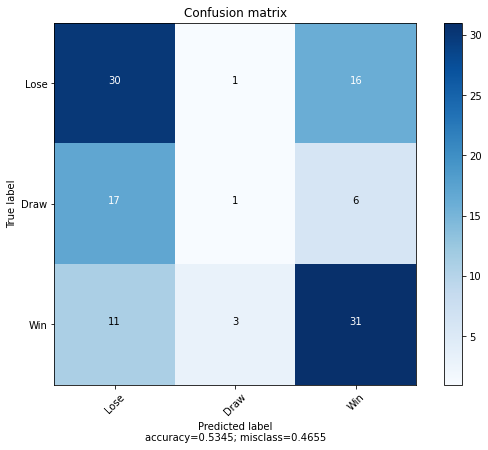

In [12]:
grid.refit

labels = ['Lose or Draw', 'Win'] if binary else ['Lose', 'Draw', 'Win']

preds = grid.predict(X_test)
plot_confusion_matrix(confusion_matrix(y_test, preds), labels, normalize=False)

In [ ]:
# Comparing Random Forest performance when using IN-GAME versus OUT-OF-GAME features

# Loop from 1 to max_est trees in the random forest
min_est = 1
max_est = 100
estimators = np.arange(min_est, max_est + 1, 1)

# Split data into training and testing
test_size=0.30

binary = False # Binary Classification Flag. 
random = 0 # None for random data split and random initialization of model. Any integer for a seed.

fig1 = go.Figure()
fig2 = go.Figure()
fig3 = go.Figure()

feature_type_list = ["out_of_game", "in_game", "all_features"]
comparison_results_dict = {}
for curr in feature_type_list:

    n_total_features = len(features_dict[curr])
    X = np.array(games_comb_df[features_dict[curr]])
    y = np.array(games_comb_df["WDL"])

    # Normalize data to mean=0 and std=1
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

    # Split data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random)
    
    n = len(estimators)
    cv_scores    = np.zeros(n)
    train_scores = np.zeros(n)
    test_scores  = np.zeros(n)

    for num_est in estimators:

        clf = RandomForestClassifier(n_estimators=num_est, random_state=random)

        # Perform cross validation on the training set (default is 5-fold CV)
        cv_results = cross_validate(clf, X_train, y_train) 
        cv_scores[num_est - min_est] = np.mean(cv_results["test_score"])

        # Fit model to training data and score it's performance on testing data
        clf.fit(X_train, y_train)
        train_scores[num_est - min_est] = clf.score(X_train, y_train)
        test_scores[num_est - min_est] = clf.score(X_test, y_test)
    
    # Add results to dictionary
    comparison_results_dict[curr + "_cv"] = cv_scores
    comparison_results_dict[curr + "_train"] = train_scores
    comparison_results_dict[curr + "_test"] = test_scores
    
    fig1.add_trace(go.Scatter(
    x=estimators, 
    y=comparison_results_dict[curr + "_cv"],
    name=curr))
    
    fig2.add_trace(go.Scatter(
    x=estimators, 
    y=comparison_results_dict[curr + "_train"],
    name=curr))
    
    fig3.add_trace(go.Scatter(
    x=estimators, 
    y=comparison_results_dict[curr + "_test"],
    name=curr))
    
# Plot figure (Cross Validation scores)
fig1.update_layout(title="Cross Validation scores",
                  xaxis_title="number of estimators in random forest",
                  yaxis_title="accuracy")
fig1.show()

# Plot figure (Accuracy on training set)
fig2.update_layout(title="Training set scores",
                  xaxis_title="number of estimators in random forest",
                  yaxis_title="accuracy")
fig2.show()

# Plot figure (Accuracy on testing set)
fig3.update_layout(title="Testing set scores",
                  xaxis_title="number of estimators in random forest",
                  yaxis_title="accuracy")
fig3.show()

## Attempt AdaBoost 

In [139]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

# Classification using Adaboost

binary = True # Binary Classification Flag. 
random = 42  # None for random data split and random initialization of model. Any integer for a seed.
scoring_method = 'accuracy'

# how many features to use? (None for all features)
n_feats = None; 

# Split data into train, test sets
X = pd.DataFrame(games_comb_df[features_array[0:n_feats]])
y = pd.DataFrame(games_comb_df['WDL'])
if binary:
    y[y==0] = -1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random, stratify=y)

pipeline = Pipeline([
        ('scale', StandardScaler()),
        ('lda', LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')),
        ('clf', AdaBoostClassifier(random_state=random, base_estimator=DecisionTreeClassifier(max_depth=1)))])

hyperparameters = {
    'clf__n_estimators' : [50, 75, 100],
    'clf__learning_rate' : [.1, 0.3, 0.5]
}

"""
hyperparameter analysis:

clf__n_estimators: best results for [50, 100]
clf__learning_rate: best results for [0.1, 0.5]

"""
               
# Do a grid search with cross validation to find the best hyperparameter values
grid = GridSearchCV(pipeline, param_grid=hyperparameters, cv=5, verbose=0, scoring=scoring_method)
grid.fit(X_train, y_train)

# Display results
cols_of_interest = ['mean_test_score', 'std_test_score', 'rank_test_score'] + [c.replace('clf', 'param_clf') for c in hyperparameters.keys()]
results = pd.DataFrame(grid.cv_results_).sort_values(by=['mean_test_score'], ascending=False)[cols_of_interest]
results.head(10) 

,mean_test_score,std_test_score,rank_test_score,param_clf__n_estimators,param_clf__learning_rate
2,0.665700,0.081782,1,100,0.1
0,0.661797,0.079423,2,50,0.1
1,0.661797,0.079423,2,75,0.1
8,0.659907,0.075692,4,100,0.5
3,0.656955,0.082876,5,50,0.3
5,0.656955,0.082876,5,100,0.3
4,0.652511,0.079795,7,75,0.3
6,0.652511,0.079795,7,50,0.5
7,0.652511,0.079795,7,75,0.5


F1 score: 0.779


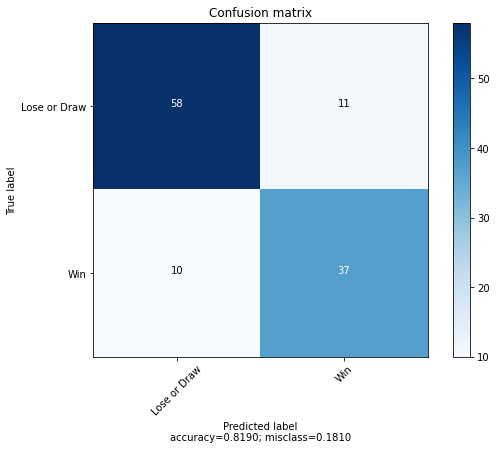

In [138]:
grid.refit

labels = ['Lose or Draw', 'Win'] if binary else ['Lose', 'Draw', 'Win']

preds = grid.predict(X_test)
from sklearn.metrics import f1_score
print("F1 score: %.3f (combines precision and recall)" % f1_score(y_test, preds))
plot_confusion_matrix(confusion_matrix(y_test, preds), labels, normalize=False)

## Play around with different Kernels in SVM

In [ ]:
# Perform cross validation to determine the best number of features according to the training set

def loop_features_cv(clf, test_size=0.3, normalize=True, random=0):
    """
    This function trains and tests a given model looping over the number of features, which increases from 1 to 22,
    and performs cross validation on the training set. Returns the average cross validation score for each amount
    of features
        Inputs:
           clf: sklearn classifier
           test_size: percentage of data to use for testing (between 0 and 1)
           normalize: boolean indicating whether to normalize/standardize the data.
           random: None for random train/test split and model initializations. Any int to supply a seed for random numbers.
        Outputs:
           cv_scores: [1x22] array of cross validation scores 
           test_scores: [1x22] array of testing accuracy values 
    """
    
    n_total_features = len(avg_importance_scores_df.index)
    
    cv_scores = np.zeros(n_total_features)
    test_scores = np.zeros(n_total_features)
    for num_features in range(1, n_total_features + 1):

        features_array = np.flip(np.array(avg_importance_scores_df.index))
        X = games_comb_df[features_array[0:num_features]]
        y = games_comb_df["WDL"]

        if normalize:
            # Normalize data to mean=0 and std=1
            X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
        
        # Split data into training and testing (random_state=0 is a random seed)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random)

        # Standardize data: 
        scaler = StandardScaler()
        # fit on training set only
        scaler.fit(X_train) 
        # apply transform to both training and testing set
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
        # Perform cross validation on the training set (default is 5-fold CV)
        cv_results = cross_validate(clf, X_train, y_train) 
        cv_scores[num_features - 1] = np.mean(cv_results["test_score"])
        
        # Fit the model using current number of features
        clf.fit(X_train, y_train)
        
        # Test the model
        test_scores[num_features - 1] = clf.score(X_test, y_test)
        
    return cv_scores, test_scores

In [ ]:
# Model 6: Support Vector [machine?] Classifier

from sklearn.svm import SVC

features_array = np.flip(np.array(avg_importance_scores_df.index))
n_total_features = len(features_array)

clf = SVC(kernel='linear') #default c=1.0 #kernel='linear' or 'rbf' (radial basis function) or 'poly'

mat_train_scores = np.zeros((100, n_total_features))
mat_test_scores = np.zeros((100, n_total_features))

for i in range(100):
    train_scores, test_scores = loop_features_cv(clf, test_size=0.3, random=None)
    mat_train_scores[i, :] = train_scores
    mat_test_scores[i, :] = test_scores

# Plot results
mean_train_scores = np.mean(mat_train_scores, axis=0)
mean_test_scores = np.mean(mat_test_scores, axis=0)

xx = np.arange(1, n_total_features + 1)
plot_accuracy(xx, mean_train_scores, mean_test_scores, clf_name="Support Vector Classifier")

# # Plot results with error bars
# train_3std = 3 * np.std(mat_train_scores, axis=0)
# test_3std = 3 * np.std(mat_test_scores, axis=0)

# df = svm_rbf_100_iter_30_70_df = {"mat_train_scores" : mat_train_scores,
#                           "mat_test_scores" : mat_test_scores,
#                           "train_3std" : train_3std, # 3* standard deviation of the accuracies over the 100 random iters
#                           "test_3std" : test_3std,
#                           "mean_train_scores" : mean_train_scores, # avg accuracies over 100 iterations 
#                           "mean_test_scores" : mean_test_scores,
#                           "num_total_features" : n_total_features,
#                           "xaxis" : xx,
#                           "description" : "SVC, RBF Kernel, C=1, 100 random iterations, 30/70 splits"}

# plot_accuracy_with_errorbar(df["xaxis"], df["mean_train_scores"], df["train_3std"], df["mean_test_scores"], df["test_3std"], 
#                             clf_name=df["description"])

In [ ]:
# Export data for the overfitting analysis generated by running the cell above 
# for different test/train splits with the error_bar plots uncommented

# svm_linear_list = [svm_linear_100_iter_20_80_df,
#                    svm_linear_100_iter_25_75_df,
#                    svm_linear_100_iter_30_70_df,
#                    svm_linear_100_iter_35_65_df,
#                    svm_linear_100_iter_40_60_df]

# for df in svm_linear_list:
#     plot_accuracy_with_errorbar(df["xaxis"], df["mean_train_scores"], df["train_3std"], df["mean_test_scores"], df["test_3std"], 
#                             clf_name=df["description"])

# # Dump SVM, Linear Kernel, 100 iter results
# import pickle
# pickle_out = open(f"./results/svm_linear_100_iters.pickle","wb")
# pickle.dump(svm_linear_list, pickle_out)
# pickle_out.close()

## Playing around with PCA

In [ ]:
# PCA feature selection can seamlessly be added to a pipeline, by just adding a PCA in between
# the scaling and the classifier
# 
# pipeline = Pipeline([
#         ('scale', StandardScaler()), 
#         ('pca', PCA(0.9)), # Retain ~90% of variaince with this PCA
#         ('clf', RandomForestClassifier(random_state=random))])

#### Old PCA code

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# get dataset
features_array = np.flip(np.array(avg_importance_scores_df.index))
X = games_comb_df[features_array]
y = games_comb_df['WDL']

# standardize dataset
X_standard = StandardScaler().fit_transform(X)

# Principal Component Analysis
pca = PCA(.90) # retain 90% of the variance
principal_components = pca.fit_transform(X_standard)
principal_df = pd.DataFrame(data = principal_components)

# Combine principal components and results in a single dataframe
target_df = pd.DataFrame(data = y.values, columns=['result'])
final_df = pd.concat([principal_df, target_df], axis=1) 
print(final_df.head())

X_pca = principal_components
y_pca = y

In [ ]:
## Scaling the data using a Standard Scaler

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_pca, test_size=0.3, random_state=0)

# Standardize data: 
scaler = StandardScaler()
# fit on training set only
scaler.fit(X_train) 
# apply transform to both training and testing set
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Train the model
clf = RandomForestClassifier(random_state=0)
# clf = GaussianNB()
# clf = SVC()

clf.fit(X_train, y_train)

# Test the model
preds = clf.predict(X_test)
score = clf.score(X_test, y_test)
print("Test accuracy: %.2f" % score)

# Confusion matrix
cm = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm, ['Lose', 'Draw', 'Win'])